## Bayesian curve fits of kinetic to the Eyring equation
Vincent Voelz
<br>Dec 12, 2021

Goal: to find estimates of $\Delta H^{\ddagger}$ and $\Delta S^{\ddagger}$ that best fit $k_{cat}$ vs. $T$, using the Eyring formula:

$$k = \kappa \big( \frac{k_B T}{h} \big) \exp( -\Delta H^{\ddagger}/RT ) \exp( +\Delta S^{\ddagger}/R ) $$


First, let's write a function that can evaluate the rate given a temperature, and some parameters:

In [1]:
import numpy as np

def k_eyring(T, dH=3.0e4, dS=-100.0, kappa=1.0):
    """Returns an estimate of the Eyring rate (in units s^{-1})
    
    INPUT
    T        temperature in K

    PARAMS
    dH.       the Delta H in J/mol
    dS.       the Delta S in J/mol/K
    """

    # Define some physical constants
    kB = 1.380649e-23       # J/K
    h  = 6.626e-34          # J*s
    R  = 8.314              # J/K/mol 

    return kappa*(kB*T/h)* np.exp( -1.0*dH/(R*T) + dS/R )
  

# Let's test this function
temps = np.array([278.15, 283.15, 288.15, 293.15, 298.15]) # 10C through 50C

#  Shahlo -- note how we are giving this function a numpy *array*, and it returns a numpy array!
# I played around with the parameter to get "reasonable" numbers
k_eyring(temps)


array([ 80.43831093, 102.96467795, 130.7150233 , 164.64782058,
       205.84908913])

### Read in the experimenal data from file

Next, we will read in the data from files `wt_1M_data.dat`, ...

Data looks like this:
```
% cat wt_1M_data.dat 
                   10C    20C    30C    40C     50C
---------------  -----  -----  -----  -----  ------
K_M (mM)          2.66   2.73   2.83   2.89    3.84
K_M error         0.2    0.4    0.22   0.13    0.14
k_cat (s^{-1})    1.76   4.08  16.89  86.27  183.15
k_cat error       0.12   0.56   1.26   3.54    6.3
k_cat/K_M         0.66   1.49   5.97  29.82   47.67
k_cat/K_M error   0.07   0.3    0.65   1.78    2.36
```

# A Bayesian curve fitting algorithm

Next, let's implement a Bayesian inference algorithm to estimate the values of $\Delta H^{\ddagger}$ and $\Delta S^{\ddagger}$ and their *uncertainty*.

Bayes' Law says that the posterior probability of the parameters $\lambda = (\Delta H^{\ddagger}, \Delta S^{\ddagger})$ given the data $D$ is proportional to the likelihood of observing the data given a model with parameters $\lambda$:

$$ P(\lambda|D) = \frac{P(D | \lambda )P(\lambda)}{P(D)} \propto P(D | \lambda )P(\lambda ) $$

Here, $P(\lambda | D)$ is the posterior probability, $P(D | \lambda )$ is the likelihood function, and $P(\lambda )$ is the *prior* distribution of the parameters.  We assume a Gaussian model for the likelihood of observing the data, where the width of the Gaussian is controlled by $\sigma_i$, the reported uncertainty of each $k_{\text{cat}}$ value indexed by $i$.  However, there must be an additional *nuisance* parameter, call it $\gamma$, that controls the overall magnitude of these relative uncertainties

$$ P(D | \lambda ) = \prod_i \frac{1}{\sqrt{2\pi(\gamma\sigma_i)^2}} \exp(-(y_i - y_i^*)^2/2(\gamma\sigma_i)^2 )$$

where $y_i$ are the values of $k_{\text{cat}}$ predicted by the model, and $D = \{ y_i^* \}$ are the experimental values.  We assume the priors $P(\Delta H^{\ddagger})$ and $P(\Delta S^{\ddagger})$ to be uniform, and use a Jeffrey's prior $P(\gamma) \sim \gamma^{-1}$ for the prior of the nuisance scaling parameter $\gamma$. 

In all, the full posterior distribution is

$$ P(\Delta H^{\ddagger},\Delta S^{\ddagger},\gamma|D) = \big( \prod_i \frac{1}{\sqrt{2\pi(\gamma\sigma_i)^2}} \exp(-(y_i(\Delta H^{\ddagger},\Delta S^{\ddagger}) - y_i^*)^2/2(\gamma\sigma_i)^2 ) \big) \frac{1}{\gamma} $$


### Algorithm

Below, we use Markov Chain Monte Carlo (MCMC) to sample the posterior $P(\Delta H^{\ddagger},\Delta S^{\ddagger},\gamma| D )$.  The best-fit values $(\Delta H^{\ddagger},\Delta S^{\ddagger})$ are the ones that maximize the posterior, and their uncertaintiesd are computed directory from the variance of each marginal distribution:

$$ P(\Delta H^{\ddagger}) = \int  \int dS^{\ddagger} d\gamma P(\Delta H^{\ddagger},\Delta S^{\ddagger},\gamma|D) $$

$$ P(\Delta S^{\ddagger}) = \int  \int dH^{\ddagger} d\gamma P(\Delta H^{\ddagger},\Delta S^{\ddagger},\gamma|D) $$







In [2]:
import numpy as np
from matplotlib import pyplot as plt


class MCMCResults(object):
    """A dumb class for storing the results of the fit"""
    
    def __init__(self, best_dH, best_dS, best_gamma,
                 dH_traj, dS_traj, gamma_traj, hist_dH_dS):
        self.best_dH    = best_dH
        self.best_dS    = best_dS
        self.best_gamma = best_gamma
        self.dH_traj    = dH_traj
        self.dS_traj    = dS_traj
        self.gamma_traj = gamma_traj
        self.hist_dH_dS = hist_dH_dS

        
class BayesianCurveFitter(object):
    """A class for reading in experimental 
    data, doing MCMC sampling, writing results, making plots, etc."""
    
    def __init__(self, datafile):
        """Initialize the class"""
        
        # read in the experimental data
        self.datafile = datafile
        self.kcat       = None
        self.kcat_error = None
        self.read_data()
        
        # temps = 10, 20, 30, 40, 50 C
        self.temps = np.array([283.15, 293.15, 303.15, 313.15, 323.15]) 
        
        # Settings for MCMC sampling
        self.results = None   # object to store the results
        self.print_every=100000
        self.traj_every=10
        
        
        ### Set default MCMC search parameters
        if datafile == 'wt_1M_data.dat':
            self.n_gamma, self.log10_gamma_min, self.log10_gamma_max = 1000, -1.0, 1.2
            self.n_dH, self.dH_min, self.dH_max = 500, 50000., 150000.0  # J/mol
            self.n_dS, self.dS_min, self.dS_max = 500, 0., 150.0  # J/K/mol
        else:
            self.n_gamma, self.log10_gamma_min, self.log10_gamma_max = 1000, -1.0, 1.2
            self.n_dH, self.dH_min, self.dH_max = 500, 0., 100000.0  # J/mol
            self.n_dS, self.dS_min, self.dS_max = 500, -50., 50.0  # J/K/mol
        
        # To enforce the Jeffrey's prior, we set the possible values of
        # gamma to be logarithmically spaced:
        dlog10_gamma = (self.log10_gamma_max - self.log10_gamma_min)/self.n_gamma
        self.gamma_values = np.power(10.0,np.arange(self.log10_gamma_min, self.log10_gamma_max, dlog10_gamma))

        self.dH_values = np.arange(self.dH_min, self.dH_max, (self.dH_max - self.dH_min)/self.n_dH)  # J/mol
        self.dS_values = np.arange(self.dS_min, self.dS_max, (self.dS_max - self.dS_min)/self.n_dS)  # J/K/mol
        
        
    def read_data(self, verbose=False):
        """Read in k_cat and k_cat error from a 'wt_1M_data.dat' 
        format data file.

        INPUT
        datafile   -- an input file with format:
                               10C    20C    30C    40C     50C
            ---------------  -----  -----  -----  -----  ------
            K_M (mM)          2.66   2.73   2.83   2.89    3.84
            K_M error         0.2    0.4    0.22   0.13    0.14
            k_cat (s^{-1})    1.76   4.08  16.89  86.27  183.15
            k_cat error       0.12   0.56   1.26   3.54    6.3
            k_cat/K_M         0.66   1.49   5.97  29.82   47.67
            k_cat/K_M error   0.07   0.3    0.65   1.78    2.36

        RETURNS
        kcat       -- values of kcat at 10C, 20C, 30C, 40C, 50C
        kcat_error -- values of standard error / uncertainty
        """

        fin = open(self.datafile)
        lines = fin.readlines()
        fin.close()

        for line in lines:
            if line.count('k_cat ') > 0 and line.count('k_cat error') == 0:
                kcat = np.array( [float(s) for s in line.split()[-5:]] )
            if line.count('k_cat error') > 0:
                kcat_error = np.array( [float(s) for s in line.split()[-5:]] )

        self.kcat       = kcat
        self.kcat_error = kcat_error


    def k_eyring(self, dH=3.0e4, dS=-100.0, kappa=1.0):
        """Returns an estimate of the Eyring rate (in units s^{-1})

        INPUT
        T        temperature in K

        PARAMS
        dH.       the Delta H in J/mol
        dS.       the Delta S in J/mol/K
        """

        # Define some physical constants
        kB = 1.380649e-23       # J/K
        h  = 6.626e-34          # J*s
        R  = 8.314              # J/K/mol 

        return kappa*(kB*self.temps/h)* np.exp( -1.0*dH/(R*self.temps) + dS/R )
  

    def neglogP(self, dH, dS, gamma):
        """Returns the (natural) log-likelihood of the posterior for the given gamma,
        and when gamma = 1.0 (the non-Bayes maximum likelihood)"""
    
        y_i = self.k_eyring(dH=dH, dS=dS)
        y_i_exp = self.kcat

        logP = 0.0
        logP += np.sum( -0.5*np.log(2.0*np.pi))
        logP += np.sum( -1.0*np.log(gamma*self.kcat_error))

        logP_MLE = logP + np.sum( -0.5*((y_i - y_i_exp)/self.kcat_error)**2 )
        logP += np.sum( -0.5*((y_i - y_i_exp)/(gamma*self.kcat_error))**2 )

        return -1.0*logP, -1.0*logP_MLE

    
    def sample(self, nsteps=10000000, print_every=100000, traj_every = 10,
                n_gamma=1000, log10_gamma_min=-1.0, log10_gamma_max=1.2,
                n_dH=500, dH_min = 50000., dH_max = 150000.0,  
                n_dS=500, dS_min = -50., dS_max = 50.0):  

        """Sample the posterior distribution using MCMC.

        NOTE: H values in J/mol, S in J/K/mol.
        """

        # Starting states
        gamma_i = int(self.n_gamma/2)
        dH_i = int(self.n_dH/2)
        dS_i = int(self.n_dS/2)

        E, E_MLE = self.neglogP(self.dH_values[dH_i], self.dS_values[dS_i], self.gamma_values[gamma_i])

        E_traj, dH_traj, dS_traj, gamma_traj = [], [], [], []
        best_E, best_E_MLE = E, E_MLE
        best_dH, best_dS, best_gamma = self.dH_values[dH_i], self.dS_values[dS_i], self.gamma_values[gamma_i]

        # Create histogram to store counts for MAP (Max a Posteriori)
        hist_dH_dS = np.zeros( (n_dH,n_dS))

        accepted_steps = 0

        for step in range(nsteps):

            # propose a new state
            new_gamma_i = gamma_i + np.random.randint(-1,2)
            new_dH_i = dH_i + np.random.randint(-1,2)
            new_dS_i = dS_i + np.random.randint(-1,2)

            # reject if the new state is out of bounds
            if (new_gamma_i < 0) or (new_gamma_i >= n_gamma):
                continue   # reject this move out of hand
            if (new_dH_i < 0) or (new_dH_i >= n_dH):
                continue
            if (new_dS_i < 0) or (new_dS_i >= n_dS):
                continue

            new_E, new_E_MLE = self.neglogP(self.dH_values[new_dH_i], self.dS_values[new_dS_i], self.gamma_values[new_gamma_i])
            
            if new_E < E:
                accept = True
            else:
                r = np.random.rand()
                if r < np.exp(-1.0*(new_E - E)):
                    accept = True
                else:
                    accept = False

            if accept:
                E = new_E
                dH_i, dS_i, gamma_i = new_dH_i, new_dS_i, new_gamma_i
                accepted_steps += 1

            # Keep track of MLE best-fit
            if E < best_E:
                best_E = E
            if E_MLE < best_E_MLE:
                best_E_MLE = E_MLE
                best_dH, best_dS, best_gamma = self.dH_values[dH_i], self.dS_values[dS_i], self.gamma_values[gamma_i]

            # store histogram count for MAP
            hist_dH_dS[dH_i,dS_i] += 1.0 

            if step%print_every == 0:
                acc_ratio = accepted_steps/(step+1)
                print('step', step, 'E=%3.4f'%E,
                      'dH=%3.3f kJ/mol'%(self.dH_values[dH_i]/1000.0),
                      'dS=%3.3f J/mol'%self.dS_values[dS_i],
                      'gamma=%3.3f'%self.gamma_values[gamma_i],
                      'acc_ratio=%1.2f'%acc_ratio)

            if step%traj_every == 0:
                dH_traj.append(self.dH_values[dH_i])
                dS_traj.append(self.dS_values[dS_i])
                gamma_traj.append(self.gamma_values[gamma_i])

        self.results = MCMCResults(best_dH, best_dS, best_gamma,
                                   dH_traj, dS_traj, gamma_traj, hist_dH_dS)


##############################################################################
#### Plotting functions that take a BayesianCurveFitter() object as input ####

def plot_trace(bcf):
    # dH_traj, dS_traj, gamma_traj, traj_every=10):

    assert (bcf.results != None)
    assert (len(bcf.results.dH_traj) == len(bcf.results.dS_traj))
    assert (len(bcf.results.dS_traj) == len(bcf.results.gamma_traj))

    N = len(bcf.results.dH_traj)
    
    ### Plot MCMC trajectories
    plt.figure(figsize=(8,5))

    plt.subplot(3,1,1)
    plt.plot(bcf.traj_every*np.arange(N), bcf.results.dH_traj)
    plt.ylabel('$\Delta H$ (J/mol)')
    plt.subplot(3,1,2)
    plt.plot(bcf.traj_every*np.arange(N), bcf.results.dS_traj)
    plt.ylabel('$\Delta S$ (J/K/mol)')
    plt.subplot(3,1,3)
    plt.plot(bcf.traj_every*np.arange(N), bcf.results.gamma_traj)
    plt.ylabel('gamma')
    plt.yscale('log')
    plt.tight_layout()

def plot_posterior_histograms(best_dH, best_dS, best_gamma,
                 dH_traj, dS_traj, gamma_traj, hist_dH_dS, kcat_label):

    ### Plot posterior histograms
    plt.figure(figsize=(8,4))
    plt.subplot(1,3,1)
    counts, bin_edges = np.histogram(dH_traj, bins=50)
    bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0
    plt.step(bin_centers/1000., counts, label='dH')
    plt.xlabel('$\Delta H$ (kJ/mol)')
    plt.subplot(1,3,2)
    counts, bin_edges = np.histogram(dS_traj, bins=50)
    bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0
    plt.step(bin_centers, counts, label='dS')
    plt.xlabel('$\Delta S$ (J/mol)')
    plt.subplot(1,3,3)
    counts, bin_edges = np.histogram(gamma_traj, bins=50)
    bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0
    plt.step(bin_centers, counts, label='gamma')
    plt.xlabel('$\gamma$ ')
    # plt.xscale('log')
    plt.tight_layout()

def plot_2D_posterior_histogram(best_dH, best_dS, best_gamma,
                 dH_traj, dS_traj, gamma_traj, hist_dH_dS, kcat_label):


    ### Plot 2D posterior histogram
    plt.figure(figsize=(6,6))
    #plt.hexbin(dH_traj, dS_traj)
    plt.contour(X, Y, Z, 20, cmap='RdGy');
    plt.xlabel('$\Delta H$')
    plt.ylabel('$\Delta S$')
    plt.tight_layout()

    best_dH_std = np.std(np.array(dH_traj))
    print('dH =', best_dH, '+/-', best_dH_std)
    best_dS_std = np.std(np.array(dS_traj))
    print('dS =', best_dS, '+/-', best_dS_std)      

def plot_curve_fit(bcf, title='', logscale=False):

    # MLE best-fit (gamma=1)
    MLE_dH, MLE_dS, MLE_gamma = bcf.results.best_dH, bcf.results.best_dS, bcf.results.best_gamma, 
    print('MLE best-fit: dH', MLE_dH, 'dS', MLE_dS)
    
    # MAP best-fit
    dH_traj, dS_traj, gamma_traj = bcf.results.dH_traj, bcf.results.dS_traj, bcf.results.gamma_traj
    hist_dH_dS = bcf.results.hist_dH_dS
    Ind = np.unravel_index(np.argmax(hist_dH_dS, axis=None), hist_dH_dS.shape)
    print(Ind)
    MAP_dH, MAP_dS = bcf.dH_values[Ind[0]], bcf.dS_values[Ind[1]]
    MAP_dH_std, MAP_dS_std = np.std(np.array(dH_traj)), np.std(np.array(dS_traj))
    print('MAP best-fit: dH =', MAP_dH, '+/-', MAP_dH_std, 'J/mol')
    print('MAP best-fit: dS =', MAP_dS, '+/-', MAP_dS_std, 'J/K/mol')
    
    MAP_kcat  = k_eyring(bcf.temps, dH=MAP_dH, dS=MAP_dS)
    upper_kcat = k_eyring(bcf.temps, dH=MAP_dH+MAP_dH_std, dS=MAP_dS+MAP_dS_std)
    lower_kcat = k_eyring(bcf.temps, dH=MAP_dH-MAP_dH_std, dS=MAP_dS-MAP_dS_std)

    ## Plot exp vs model
    plt.figure(figsize=(4,4))

    # experimental data
    plt.fill_between(bcf.temps, bcf.kcat+bcf.kcat_error, bcf.kcat-bcf.kcat_error, alpha=0.4)
    plt.plot(bcf.temps, bcf.kcat, label='exp')

    # model data
    plt.fill_between(bcf.temps, upper_kcat, lower_kcat, alpha=0.4)
    plt.plot(bcf.temps, MAP_kcat, label='fit')

    if logscale:
        plt.yscale('log')
    plt.xlabel("temperature (K)")
    plt.ylabel("$k_{cat}$ ($s^{-1}$)")
    plt.legend(loc='best')
    plt.title(title)

    plt.tight_layout()
    plt.show()



step 0 E=573.1471 dH=100.200 kJ/mol dS=75.300 J/mol gamma=1.265 acc_ratio=1.00
step 100000 E=10.7200 dH=93.000 kJ/mol dS=86.700 J/mol gamma=4.225 acc_ratio=0.77
step 200000 E=11.0101 dH=93.000 kJ/mol dS=86.100 J/mol gamma=2.860 acc_ratio=0.77
step 300000 E=10.9946 dH=89.400 kJ/mol dS=74.100 J/mol gamma=4.747 acc_ratio=0.78
step 400000 E=10.8277 dH=93.600 kJ/mol dS=87.900 J/mol gamma=3.381 acc_ratio=0.79
step 500000 E=12.5424 dH=101.600 kJ/mol dS=114.000 J/mol gamma=6.801 acc_ratio=0.79
step 600000 E=10.5470 dH=91.000 kJ/mol dS=80.400 J/mol gamma=4.036 acc_ratio=0.80
step 700000 E=14.9966 dH=83.800 kJ/mol dS=59.400 J/mol gamma=11.754 acc_ratio=0.81
step 800000 E=12.3266 dH=95.200 kJ/mol dS=94.500 J/mol gamma=6.564 acc_ratio=0.81
step 900000 E=11.6589 dH=80.800 kJ/mol dS=47.400 J/mol gamma=4.652 acc_ratio=0.80
step 1000000 E=13.3662 dH=107.800 kJ/mol dS=132.900 J/mol gamma=7.998 acc_ratio=0.81
step 1100000 E=14.4514 dH=99.400 kJ/mol dS=108.300 J/mol gamma=11.288 acc_ratio=0.81
step 12000

step 9900000 E=12.4138 dH=96.400 kJ/mol dS=96.600 J/mol gamma=7.451 acc_ratio=0.81
MLE best-fit: dH 100000.0 dS 75.0
(202, 260)
MAP best-fit: dH = 90400.0 +/- 9664.692321235612 J/mol
MAP best-fit: dS = 78.0 +/- 29.416897802509514 J/K/mol


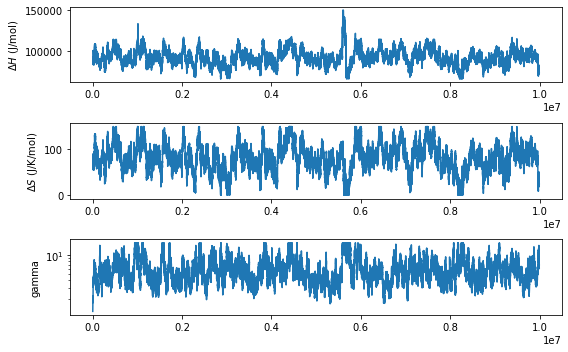

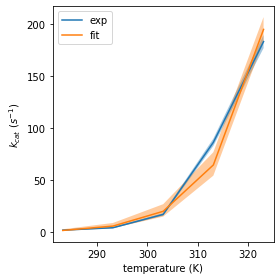

MLE best-fit: dH 100000.0 dS 75.0
(202, 260)
MAP best-fit: dH = 90400.0 +/- 9664.692321235612 J/mol
MAP best-fit: dS = 78.0 +/- 29.416897802509514 J/K/mol


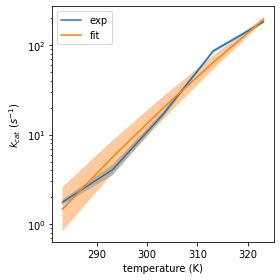

In [3]:
bcf_1M =  BayesianCurveFitter('wt_1M_data.dat')
bcf_1M.sample()

plot_trace(bcf_1M)
plot_curve_fit(bcf_1M)
plot_curve_fit(bcf_1M, logscale=True)

step 0 E=16313299.0851 dH=50.000 kJ/mol dS=0.000 J/mol gamma=1.259 acc_ratio=0.00
step 100000 E=12.4148 dH=64.400 kJ/mol dS=3.200 J/mol gamma=0.607 acc_ratio=0.37
step 200000 E=13.5219 dH=66.800 kJ/mol dS=11.600 J/mol gamma=0.953 acc_ratio=0.36
step 300000 E=12.7851 dH=64.600 kJ/mol dS=3.400 J/mol gamma=1.518 acc_ratio=0.41
step 400000 E=13.6431 dH=66.800 kJ/mol dS=11.600 J/mol gamma=0.929 acc_ratio=0.46
step 500000 E=11.7937 dH=63.600 kJ/mol dS=0.600 J/mol gamma=1.365 acc_ratio=0.46
step 600000 E=11.4995 dH=65.200 kJ/mol dS=5.800 J/mol gamma=0.798 acc_ratio=0.44
step 700000 E=17.3573 dH=65.600 kJ/mol dS=5.400 J/mol gamma=4.119 acc_ratio=0.45
step 800000 E=13.9215 dH=59.600 kJ/mol dS=-12.800 J/mol gamma=1.407 acc_ratio=0.48
step 900000 E=13.0618 dH=65.200 kJ/mol dS=6.200 J/mol gamma=1.927 acc_ratio=0.49
step 1000000 E=13.6954 dH=65.200 kJ/mol dS=5.200 J/mol gamma=1.869 acc_ratio=0.50
step 1100000 E=13.4435 dH=66.000 kJ/mol dS=8.600 J/mol gamma=2.187 acc_ratio=0.51
step 1200000 E=15.062

MLE best-fit: dH 50000.0 dS 7.105427357601002e-13
(321, 263)
MAP best-fit: dH = 64200.0 +/- 3408.8354251214864 J/mol
MAP best-fit: dS = 2.6000000000007475 +/- 11.342003944760627 J/K/mol


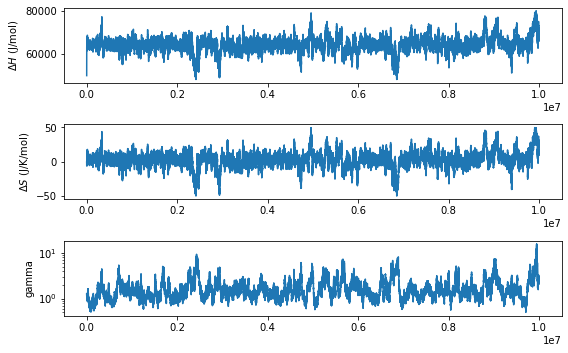

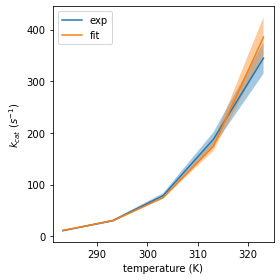

MLE best-fit: dH 50000.0 dS 7.105427357601002e-13
(321, 263)
MAP best-fit: dH = 64200.0 +/- 3408.8354251214864 J/mol
MAP best-fit: dS = 2.6000000000007475 +/- 11.342003944760627 J/K/mol


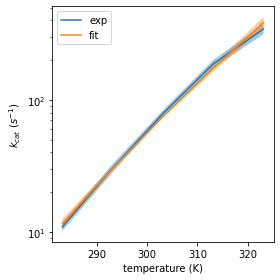

In [4]:
bcf_2M =  BayesianCurveFitter('wt_2M_data.dat')
bcf_2M.sample()

plot_trace(bcf_2M)
plot_curve_fit(bcf_2M)
plot_curve_fit(bcf_2M, logscale=True)

step 0 E=16165628.7691 dH=50.200 kJ/mol dS=0.000 J/mol gamma=1.265 acc_ratio=1.00
step 100000 E=12.7472 dH=70.000 kJ/mol dS=22.400 J/mol gamma=1.557 acc_ratio=0.58
step 200000 E=13.1138 dH=67.600 kJ/mol dS=14.800 J/mol gamma=1.443 acc_ratio=0.58
step 300000 E=12.2934 dH=67.200 kJ/mol dS=13.000 J/mol gamma=1.365 acc_ratio=0.56
step 400000 E=16.7490 dH=74.600 kJ/mol dS=36.600 J/mol gamma=4.078 acc_ratio=0.58
step 500000 E=16.5278 dH=74.400 kJ/mol dS=36.800 J/mol gamma=4.036 acc_ratio=0.61
step 600000 E=14.2561 dH=70.400 kJ/mol dS=23.600 J/mol gamma=2.585 acc_ratio=0.63
step 700000 E=14.4133 dH=68.800 kJ/mol dS=18.400 J/mol gamma=0.639 acc_ratio=0.59
step 800000 E=11.9484 dH=68.200 kJ/mol dS=16.400 J/mol gamma=1.018 acc_ratio=0.57
step 900000 E=14.3975 dH=68.600 kJ/mol dS=17.400 J/mol gamma=2.664 acc_ratio=0.56
step 1000000 E=12.2183 dH=69.400 kJ/mol dS=20.200 J/mol gamma=1.098 acc_ratio=0.56
step 1100000 E=12.7309 dH=66.800 kJ/mol dS=12.000 J/mol gamma=0.997 acc_ratio=0.54
step 1200000 E

MLE best-fit: dH 50000.0 dS 7.105427357601002e-13
(341, 332)
MAP best-fit: dH = 68200.0 +/- 3283.7465352562517 J/mol
MAP best-fit: dS = 16.400000000000944 +/- 10.71979665017419 J/K/mol


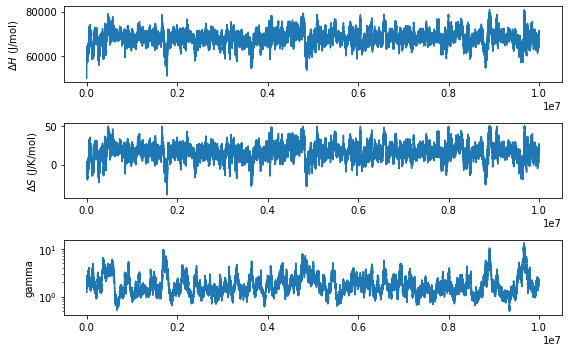

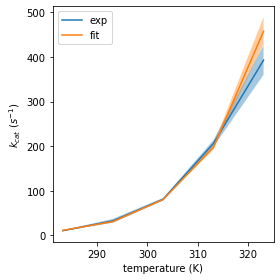

MLE best-fit: dH 50000.0 dS 7.105427357601002e-13
(341, 332)
MAP best-fit: dH = 68200.0 +/- 3283.7465352562517 J/mol
MAP best-fit: dS = 16.400000000000944 +/- 10.71979665017419 J/K/mol


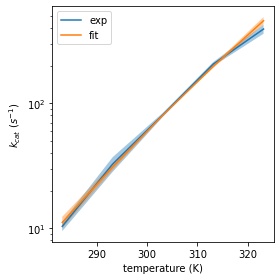

In [5]:
bcf_3M =  BayesianCurveFitter('wt_3M_data.dat')
bcf_3M.sample()

plot_trace(bcf_3M)
plot_curve_fit(bcf_3M)
plot_curve_fit(bcf_3M, logscale=True)

step 0 E=42034651.1854 dH=50.000 kJ/mol dS=0.000 J/mol gamma=1.259 acc_ratio=0.00
step 100000 E=13.3011 dH=68.200 kJ/mol dS=14.800 J/mol gamma=3.296 acc_ratio=0.51
step 200000 E=17.5717 dH=62.800 kJ/mol dS=-4.200 J/mol gamma=8.500 acc_ratio=0.60
step 300000 E=13.5506 dH=71.400 kJ/mol dS=25.000 J/mol gamma=2.371 acc_ratio=0.65
step 400000 E=16.9057 dH=58.000 kJ/mol dS=-18.000 J/mol gamma=4.422 acc_ratio=0.68
step 500000 E=15.1680 dH=66.200 kJ/mol dS=9.200 J/mol gamma=3.381 acc_ratio=0.70
step 600000 E=16.6862 dH=60.600 kJ/mol dS=-9.600 J/mol gamma=2.572 acc_ratio=0.69
step 700000 E=14.6594 dH=66.400 kJ/mol dS=8.800 J/mol gamma=4.819 acc_ratio=0.68
step 800000 E=13.4558 dH=70.600 kJ/mol dS=22.200 J/mol gamma=2.396 acc_ratio=0.68
step 900000 E=13.1921 dH=67.600 kJ/mol dS=13.200 J/mol gamma=2.336 acc_ratio=0.69
step 1000000 E=16.8409 dH=76.200 kJ/mol dS=40.200 J/mol gamma=7.047 acc_ratio=0.68
step 1100000 E=14.3664 dH=66.400 kJ/mol dS=9.400 J/mol gamma=1.860 acc_ratio=0.69
step 1200000 E=1

MLE best-fit: dH 50000.0 dS 7.105427357601002e-13
(337, 311)
MAP best-fit: dH = 67400.0 +/- 4110.298844955387 J/mol
MAP best-fit: dS = 12.200000000000884 +/- 13.480234803866145 J/K/mol


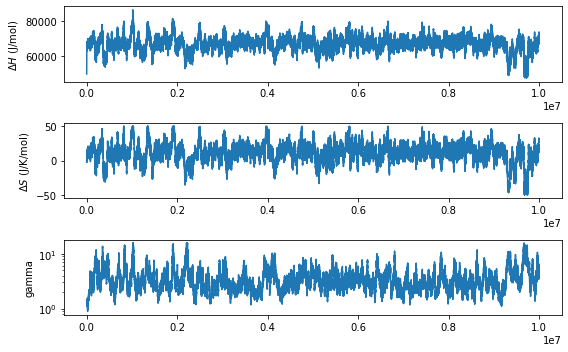

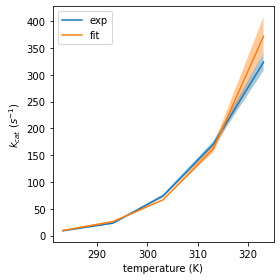

MLE best-fit: dH 50000.0 dS 7.105427357601002e-13
(337, 311)
MAP best-fit: dH = 67400.0 +/- 4110.298844955387 J/mol
MAP best-fit: dS = 12.200000000000884 +/- 13.480234803866145 J/K/mol


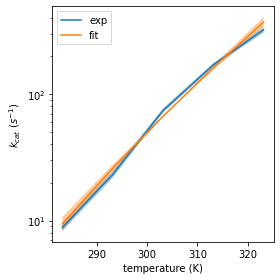

In [6]:
bcf_4M =  BayesianCurveFitter('wt_4M_data.dat')
bcf_4M.sample()

plot_trace(bcf_4M)
plot_curve_fit(bcf_4M)
plot_curve_fit(bcf_4M, logscale=True)

In [7]:
# Pickle the results
import pickle
pickle.dump( bcf_1M, open( "bcf_1M.pkl", "wb" ) )
pickle.dump( bcf_2M, open( "bcf_2M.pkl", "wb" ) )
pickle.dump( bcf_3M, open( "bcf_3M.pkl", "wb" ) )
pickle.dump( bcf_4M, open( "bcf_4M.pkl", "wb" ) )

In [8]:
# Load the results in from the pickle
import pickle
bcf_1M_loaded = pickle.load( open( "bcf_1M.pkl", "rb" ) )
bcf_2M_loaded = pickle.load( open( "bcf_2M.pkl", "rb" ) )
bcf_3M_loaded = pickle.load( open( "bcf_3M.pkl", "rb" ) )
bcf_4M_loaded = pickle.load( open( "bcf_4M.pkl", "rb" ) )